In [1]:
# ----------------------
# Load required packages
# ----------------------
import copy
import gc
import sys, getopt
import ujson as json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import multiprocessing as mp
from multiprocessing import Pool
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# Path where figures and results should be stored
fig_path = '../../results/predictions/national/schools-easter-FvdB/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

In [3]:
# -----------------------
# Load samples dictionary
# -----------------------

from covid19model.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+'BE_WAVE2_R0_COMP_EFF_2021-05-10.json', wave=2)
warmup = int(samples_dict['warmup'])

/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


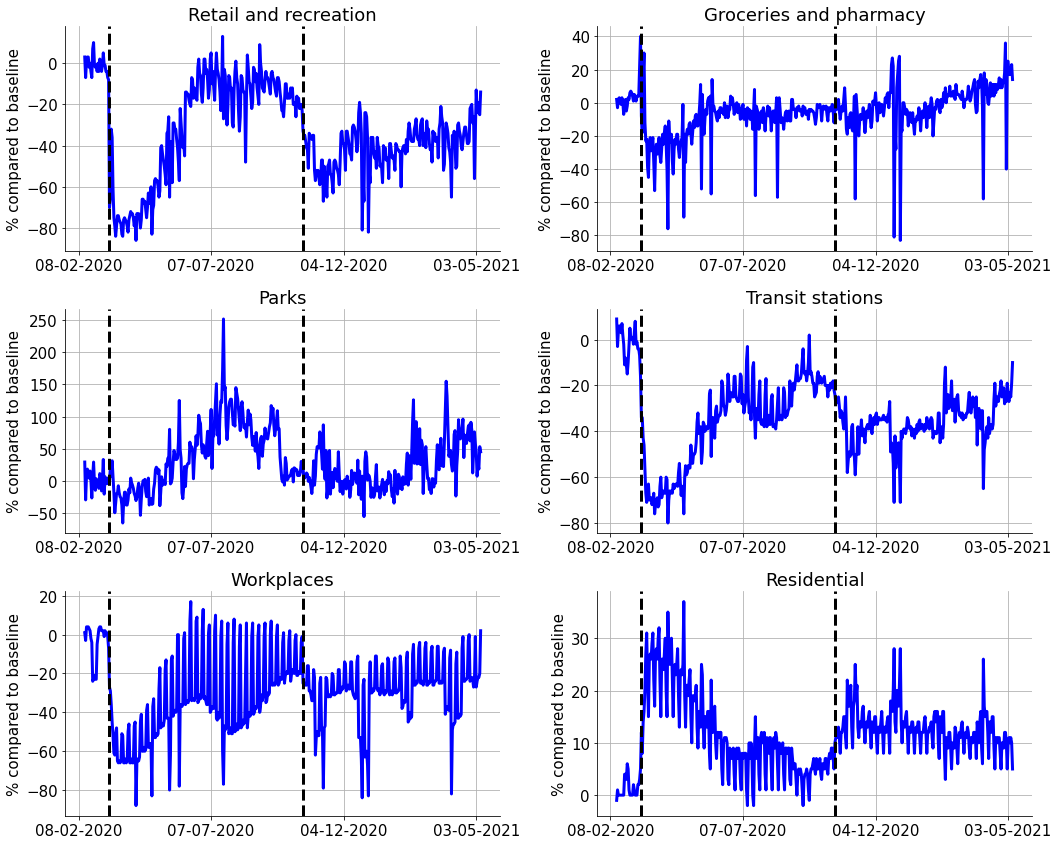

In [5]:
# ---------
# Load data
# ---------

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Sciensano public data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Sciensano mortality data
df_sciensano_mortality =sciensano.get_mortality_data()
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False,plot=True)
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()
# Start of data collection
start_data = df_sciensano.idxmin()
# Start of calibration warmup and beta
start_calibration = samples_dict['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict['end_calibration']

In [6]:
# ------------------------------
# Function to add binomial draws
# ------------------------------

from covid19model.models.utils import add_poisson, output_to_visuals

# -----------------------------------------
# Define sampling function with vaccination
# -----------------------------------------

from covid19model.models.utils import draw_fcn_WAVE2

In [11]:
# ---------------------------
# Time-dependant VOC function
# ---------------------------

from covid19model.models.time_dependant_parameter_fncs import make_VOC_function, VOC_wrapper_func
VOC_function = make_VOC_function()

In [12]:
# -----------------------------------
# Time-dependant vaccination function
# -----------------------------------

from covid19model.models.time_dependant_parameter_fncs import  make_vaccination_function, vacc_strategy
sciensano_first_dose, df_sciensano_start, df_sciensano_end = make_vaccination_function(df_sciensano)

In [13]:
# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, ramp_fun, delayed_ramp_fun
contact_matrix_4prev, all_contact, all_contact_no_schools = make_contact_matrix_function(df_google, Nc_all)

# Define policy function
def policies_wave2(t, states, param, l , prev_schools, prev_work, prev_rest, prev_home, scenario=0):
    
    # Convert tau and l to dates
    l_days = pd.Timedelta(l, unit='D')

    # Define key dates of first wave
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer holidays
    t4 = pd.Timestamp('2020-09-01') # end of summer holidays

    # Define key dates of second wave
    t5 = pd.Timestamp('2020-10-19') # lockdown (1)
    t6 = pd.Timestamp('2020-11-02') # lockdown (2)
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # Christmas holiday starts
    t9 = pd.Timestamp('2021-01-04') # Christmas holiday ends
    t10 = pd.Timestamp('2021-02-15') # Spring break starts
    t11 = pd.Timestamp('2021-02-21') # Spring break ends
    if scenario == 0:
        # Paasvakantie as is
        t12 = pd.Timestamp('2021-04-02') 
        t13 = pd.Timestamp('2021-04-18') 
    elif scenario == 1:
        # Extend one week before --> chosen
        t12 = pd.Timestamp('2021-03-26') 
        t13 = pd.Timestamp('2021-04-18')
    elif scenario == 2:
        # Extend one week after
        t12 = pd.Timestamp('2021-04-02') 
        t13 = pd.Timestamp('2021-04-25')
    elif scenario == 3:
        # Shift one week
        t12 = pd.Timestamp('2021-03-26') 
        t13 = pd.Timestamp('2021-04-11')
    elif scenario == 4:
        # No easter holiday
        t12 = pd.Timestamp('2021-04-02') 
        t13 = pd.Timestamp('2021-04-02') 
    elif scenario == 5:
        # Close schools
        t12 = pd.Timestamp('2021-03-26') 
        t13 = pd.Timestamp('2021-06-30') 
        
    t14 = pd.Timestamp('2021-07-01') # Summer holiday starts

    t = pd.Timestamp(t.date())
    # First wave
    if t <= t1:
        return all_contact(t)
    elif t1 < t < t1 :
        return all_contact(t)
    elif t1 < t <= t1 + l_days:
        policy_old = all_contact(t)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, t1, l)
    elif t1 + l_days < t <= t2:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t2 < t <= t3:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t3 < t <= t4:
        return contact_matrix_4prev(t, school=0)
    # Second wave
    elif t4 < t <= t5 :
        return contact_matrix_4prev(t, school=1)
    elif t5 < t <= t5 + l_days:
        policy_old = contact_matrix_4prev(t, school=1)
        policy_new = contact_matrix_4prev(t, prev_schools, prev_work, prev_rest, 
                                    school=1)
        return ramp_fun(policy_old, policy_new, t, t5, l)
    elif t5 + l_days < t <= t6:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t6 < t <= t7:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1) 
    elif t8 < t <= t9:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t9 < t <= t10:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t10 < t <= t11:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)    
    elif t11 < t <= t12:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t12 < t <= t13:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0) 
    elif t13 < t <= t14:
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1) 
    else:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)

In [14]:
# -------------------------------------
# Initialize the model with vaccination
# -------------------------------------

# Model initial condition on September 1st
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/initial_states_2020-09-01.json', 'r') as fp:
    initial_states_vacc = json.load(fp)  
    
params_vacc = model_parameters.get_COVID19_SEIRD_parameters(vaccination=True)
# Update with additional parameters for social policy function
params_vacc.update({'l': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5,'prev_home': 0.5, 'scenario': 1})

# Update with additional parameters for vaccination
params_vacc.update(
    {'vacc_order': np.array(range(9))[::-1], 'daily_dose': 55000,
     'refusal': 0.3*np.ones(9), 'delay': 21, 'df_sciensano_start': df_sciensano_start,
     'df_sciensano_end': df_sciensano_end, 'sciensano_first_dose': sciensano_first_dose}
)

# Append VOC parameters
params_vacc.update({'VOC_function': VOC_function})

# Initialize model
model_vacc = models.COVID19_SEIRD_vacc(initial_states_vacc, params_vacc,
                        time_dependent_parameters={'Nc': policies_wave2, 'N_vacc': vacc_strategy, 'alpha': VOC_wrapper_func})

In [15]:
# -----------------
# Scenario settings
# -----------------

scenarios = [0,1,2,3,4,5]
start_sim = '2020-09-01'
end_sim = '2021-09-01'
n_samples = 200
n_draws = 1
simulate = True
save = True

if simulate:
    # ---------------------------
    # Pre-allocation of dataframe
    # ---------------------------
    index = pd.date_range(start=start_sim, end=end_sim)
    columns = [['0','0','0','1','1','1','2','2','2','3','3','3','4','4','4'],
                ['mean','LL','UL','mean','LL','UL','mean','LL','UL','mean','LL','UL','mean','LL','UL']]
    tuples = list(zip(*columns))
    columns = pd.MultiIndex.from_tuples(tuples, names=["School scenario", "Model output"])
    data = np.zeros([len(index),15])
    df_sim = pd.DataFrame(data=data, index=index, columns=columns)

    # -------------------
    # Perform simulations
    # -------------------
    for idx,scenario in enumerate(scenarios):
        print('Simulating scenario '+str(scenario))
        model_vacc.parameters.update({'scenario': scenario})
        out_vacc = model_vacc.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn_WAVE2,samples=samples_dict)
        simtime, mean, median, LL, UL = add_poisson('H_in', out_vacc, n_samples, n_draws)
        df_sim[str(scenario), "mean"] = mean
        df_sim[str(scenario), "LL"] = LL
        df_sim[str(scenario), "UL"] = UL

    # --------------
    # Save dataframe
    # --------------
    if save:
        df_sim.to_csv('../../results/predictions/national/schools-easter-FVdB/simulations-schools-easter.csv')
    
else:
    df_sim = pd.read_csv('../../results/predictions/national/schools-easter-FVdB/simulations-schools-easter.csv', header=[0,1,2], index_col=0, parse_dates=True)

Simulating scenario 0
Simulating scenario 1
Simulating scenario 2
Simulating scenario 3
Simulating scenario 4
Simulating scenario 5


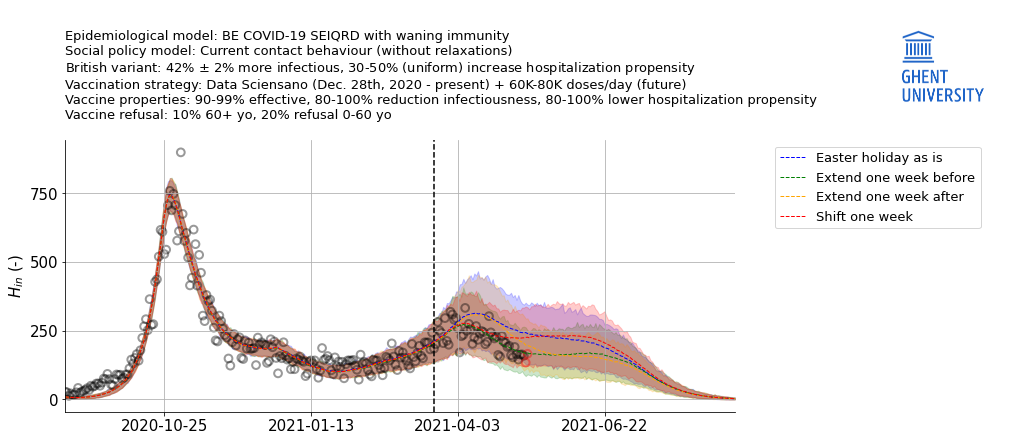

In [16]:
scenarios = [0,1,2,3]
colors = ['blue','green','orange','red']
fig,ax = plt.subplots(figsize=(12,5))
for idx,scenario in enumerate(scenarios):
    ax.plot(df_sim.index, df_sim[str(scenario), 'mean'],'--', color=colors[idx], linewidth=1)
    ax.fill_between(df_sim.index, df_sim[str(scenario), 'LL'], df_sim[str(scenario), 'UL'], alpha=0.20, color = colors[idx])

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)

ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
ax.set_ylabel('$H_{in}$ (-)')
ax.set_title('Epidemiological model: BE COVID-19 SEIQRD with waning immunity\nSocial policy model: Current contact behaviour (without relaxations)\nBritish variant: 42% $\pm$ 2% more infectious, 30-50% (uniform) increase hospitalization propensity\nVaccination strategy: Data Sciensano (Dec. 28th, 2020 - present) + 60K-80K doses/day (future)\nVaccine properties: 90-99% effective, 80-100% reduction infectiousness, 80-100% lower hospitalization propensity\nVaccine refusal: 10% 60+ yo, 20% refusal 0-60 yo\n',loc='left',fontsize=13)
ax.legend(['Easter holiday as is','Extend one week before', 'Extend one week after','Shift one week'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.axvline('2021-03-21',linestyle='--',color='black',linewidth=1.5)

im = mpimg.imread('logo_UGent_EN_RGB_2400_color-on-white.png')
newax = fig.add_axes([0.89, 0.90, 0.35, 0.35], anchor='NE', zorder=-1)
newax.imshow(im)
newax.axis('off')

fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_0.pdf', dpi=300, bbox_inches='tight')
fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_0.jpg', dpi=300, bbox_inches='tight')

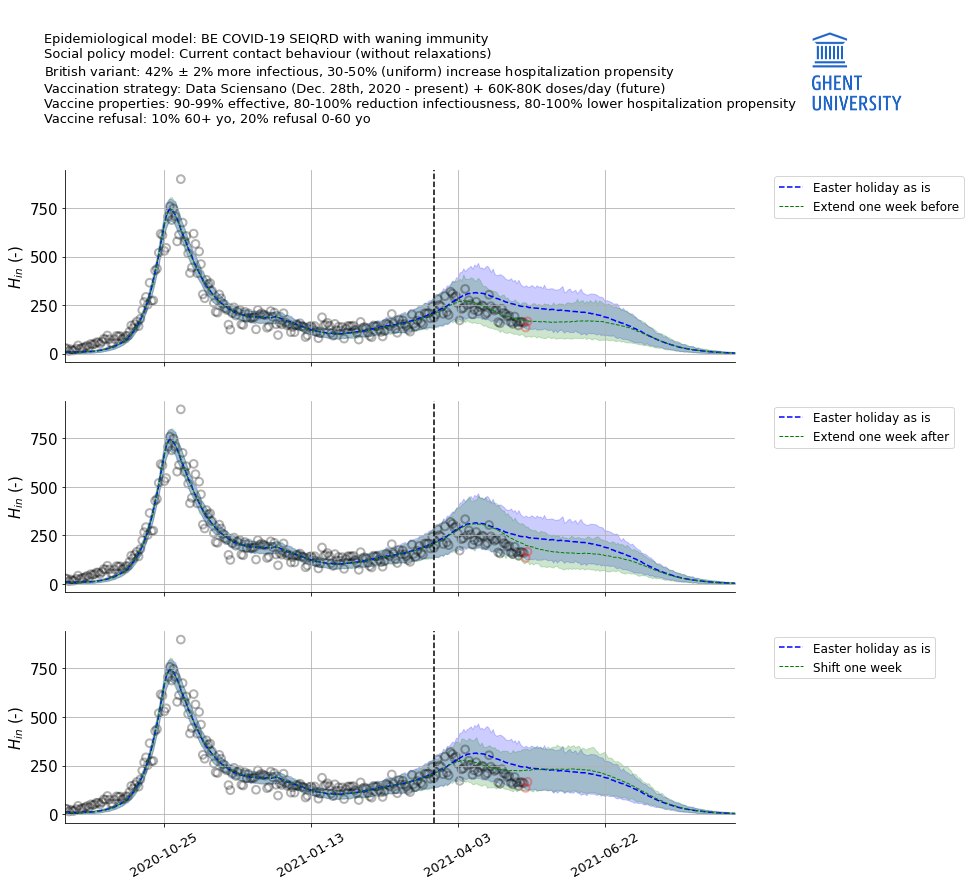

In [17]:
start_calibration = start_sim
scenarios = [0,1,2,3]
legend_entries = ['Extend one week before', 'Extend one week after', 'Shift one week']
fig,axes = plt.subplots(ncols=1,nrows=3,figsize=(12,12), sharey=True, sharex=True)

# -------------------------------------
# Plot baseline scenario in every graph
# -------------------------------------

for idx,ax in enumerate(axes):
        ax.plot(df_sim.index, df_sim["0","mean"],'--', color='blue', linewidth=1.5)
        ax.fill_between(df_sim.index, df_sim["0","LL"], df_sim["0","UL"],alpha=0.20, color = 'blue')


for idx,scenario in enumerate(scenarios[1:]):

    # -----------
    # Add to plot
    # -----------
        ax = axes[idx]
        ax.plot(df_sim.index, df_sim[str(scenario),"mean"], '--', color='green', linewidth=1)
        ax.fill_between(df_sim.index, df_sim[str(scenario),"LL"], df_sim[str(scenario),"UL"], alpha=0.20, color = 'green')

        ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.3, linestyle='None', facecolors='none', s=60, linewidth=2)
        ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.3, linestyle='None', facecolors='none', s=60, linewidth=2)

        ax = _apply_tick_locator(ax)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.xaxis.set_tick_params(labelsize=13, rotation=30)
        ax.set_xlim('2020-09-01',end_sim)
        ax.set_ylabel('$H_{in}$ (-)')
        ax.legend(['Easter holiday as is',legend_entries[idx]], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
        ax.axvline('2021-03-21',linestyle='--',color='black',linewidth=1.5)

im = mpimg.imread('logo_UGent_EN_RGB_2400_color-on-white.png')
newax = fig.add_axes([0.95, 0.87, 0.2, 0.2], anchor='NE', zorder=-1)
newax.imshow(im)
newax.axis('off')

#fig.text(x=0.25,y=0.25,s='preliminary', rotation=30, alpha=0.2, fontsize = 110)
fig.suptitle('Epidemiological model: BE COVID-19 SEIQRD with waning immunity\nSocial policy model: Current contact behaviour (without relaxations)\nBritish variant: 42% $\pm$ 2% more infectious, 30-50% (uniform) increase hospitalization propensity\nVaccination strategy: Data Sciensano (Dec. 28th, 2020 - present) + 60K-80K doses/day (future)\nVaccine properties: 90-99% effective, 80-100% reduction infectiousness, 80-100% lower hospitalization propensity\nVaccine refusal: 10% 60+ yo, 20% refusal 0-60 yo\n', 
             x=0.1, y=1.04, ha='left', fontsize=13)

fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_3.pdf', dpi=300, bbox_inches='tight')
fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_3.jpg', dpi=300, bbox_inches='tight')

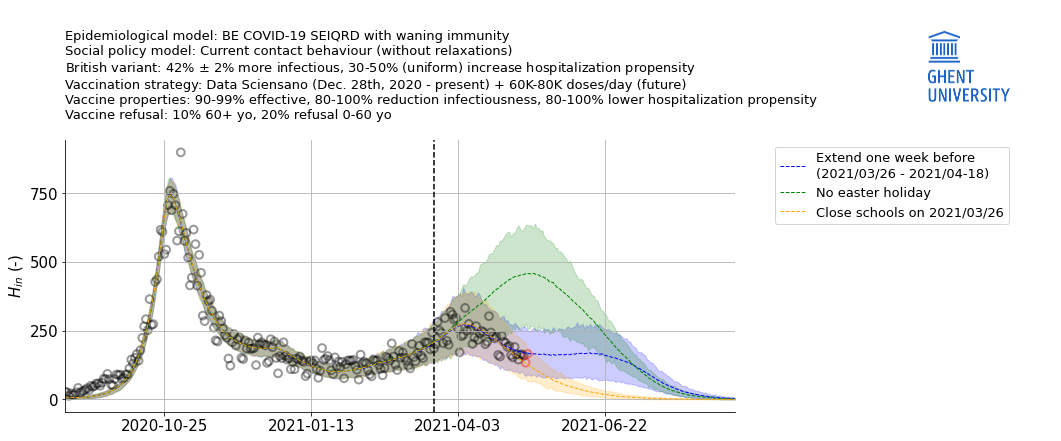

In [18]:
scenarios = [1,4,5]
colors = ['blue','green','orange']
fig,ax = plt.subplots(figsize=(12,5))
for idx,scenario in enumerate(scenarios):
    ax.plot(df_sim.index, df_sim[str(scenario),'mean'],'--', color=colors[idx], linewidth=1)
    ax.fill_between(df_sim.index, df_sim[str(scenario),'LL'], df_sim[str(scenario),'UL'],alpha=0.20, color = colors[idx])

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):end_sim], color='red', alpha=0.4, linestyle='None', facecolors='none', s=60, linewidth=2)
ax.axvline('2021-03-21',linestyle='--',color='black',linewidth=1.5)

ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)
ax.set_ylabel('$H_{in}$ (-)')
ax.set_title('Epidemiological model: BE COVID-19 SEIQRD with waning immunity\nSocial policy model: Current contact behaviour (without relaxations)\nBritish variant: 42% $\pm$ 2% more infectious, 30-50% (uniform) increase hospitalization propensity\nVaccination strategy: Data Sciensano (Dec. 28th, 2020 - present) + 60K-80K doses/day (future)\nVaccine properties: 90-99% effective, 80-100% reduction infectiousness, 80-100% lower hospitalization propensity\nVaccine refusal: 10% 60+ yo, 20% refusal 0-60 yo\n',loc='left',fontsize=13)
ax.legend(['Extend one week before\n(2021/03/26 - 2021/04-18)','No easter holiday', 'Close schools on 2021/03/26'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

im = mpimg.imread('logo_UGent_EN_RGB_2400_color-on-white.png')
newax = fig.add_axes([0.92, 0.90, 0.35, 0.35], anchor='NE', zorder=-1)
newax.imshow(im)
newax.axis('off')

fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_2.pdf', dpi=300, bbox_inches='tight')
fig.savefig('../../results/predictions/national/schools-easter-FVdB/twallema-schools_2.jpg', dpi=300, bbox_inches='tight')

In [ ]:
plt.plot()